In [1]:
import h5py,pandas as pd, numpy as np
import os.path
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow import keras
from tensorflow.keras import layers
import itertools
import matplotlib.pyplot as plt

Aquisition des données pour utilisation dans Jupyter (local)

In [13]:
from data import dataread, datatreat_A1

from tools import save_model, save_results, plot_loss_acc_history, loss_generator, save_submission, plot_confusion_matrix

In [3]:
X, y, X_final = dataread()

In [24]:
# CNN deep ConvNet
def cnn_4(loss='binary_crossentropy'):
  model = keras.Sequential(
    [
      layers.Conv2D(filters=25, kernel_size=(1,10), strides=1, padding='same', input_shape=(7,500,1)),
      layers.Conv2D(filters=25, kernel_size=(7,1), strides=1, padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.1, epsilon=0.00001),
      layers.Activation('elu'),
      layers.MaxPool2D(pool_size=(1,3), strides=(1,3), padding='same'),
      
      layers.Dropout(0.5),
      layers.Conv2D(filters=50, kernel_size=(1,10), strides=1, padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.1, epsilon=0.00001),
      layers.Activation('elu'),
      layers.MaxPool2D(pool_size=(1,3), strides=(1,3), padding='same'),

      layers.Dropout(0.5),
      layers.Conv2D(filters=100, kernel_size=(1,10), strides=1, padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.1, epsilon=0.00001),
      layers.Activation('elu'),
      layers.MaxPool2D(pool_size=(1,3), strides=(1,3), padding='same'),

      layers.Dropout(0.5),
      layers.Conv2D(filters=200, kernel_size=(1,10), strides=1, padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.1, epsilon=0.00001),
      layers.Activation('elu'),
      layers.MaxPool2D(pool_size=(1,3), strides=(1,3), padding='same'),

      layers.Flatten(),  
      layers.Dense(1, activation='sigmoid')
    ]
  )
  model.compile(
    loss=loss,
    optimizer=keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy'), keras.metrics.AUC(name='AUC')]
  )
  model.summary()

  return model

In [16]:
def test(predicts, y_test, id):
    predicts2=np.transpose(predicts>0.5)[0]
    accuracy=(np.count_nonzero(predicts2==y_test))/len(y_test)*100
    roc=roc_auc_score(y_test, predicts2)
    f1_macro=f1_score(y_test, predicts2, average='macro')
    f1_wei=f1_score(y_test, predicts2, average='weighted')

    print('')
    print('Accuracy : ' + str(accuracy))
    print('')
    print('ROC AUC : ' + str(roc))
    print('')
    print('f1 score (macro) : ' + str(f1_macro))
    print('')
    print('f1 score (weighted) : ' + str(f1_wei))
    
    cm = confusion_matrix(y_true=y_test, y_pred=predicts2)
    cm_labels = ['male','female']
    plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix', id=id)

    return accuracy, roc, f1_macro, f1_wei


def test_1(model, X_test, y_test=None, id=None, increase_dim=True):
    predicts=[]
    for i in range(40):
        X_test_i=X_test[:,i,:,:]
        if increase_dim:
            X_test_i=X_test_i.reshape(X_test_i.shape[0], X_test_i.shape[1], X_test_i.shape[2], 1)
        predicts.append(model.predict(X_test_i))
    predicts=np.mean(predicts, axis=0)

    return test(predicts, y_test, id)

In [61]:
epochs=60
batch_size=68
validation_split=0.1

In [7]:
X_train, X_test, y_train, y_test, prop_HF = datatreat_A1(x0=X, y0=y, train_size=0.8, Shuffle=True, preprocess="Standardization", ratio="50/50", balancing_method="duplicate/remove")

La proportion H/F des données d'entraînement est de 1.0
L'échantillon de training comporte 30240 frames


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 7, 500, 25)        275       
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 7, 500, 25)        4375      
_________________________________________________________________
batch_normalization_100 (Bat (None, 7, 500, 25)        100       
_________________________________________________________________
activation_100 (Activation)  (None, 7, 500, 25)        0         
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 7, 167, 25)        0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 7, 167, 25)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 7, 167, 50)      

Epoch 29/60
401/401 [==============================] - 17s 42ms/step - loss: 0.5699 - accuracy: 0.6991 - AUC: 0.7717 - val_loss: 0.7062 - val_accuracy: 0.6025 - val_AUC: 0.7305
Epoch 30/60
401/401 [==============================] - 17s 42ms/step - loss: 0.5566 - accuracy: 0.7113 - AUC: 0.7844 - val_loss: 0.6309 - val_accuracy: 0.6554 - val_AUC: 0.7368
Epoch 31/60
401/401 [==============================] - 16s 41ms/step - loss: 0.5590 - accuracy: 0.7070 - AUC: 0.7822 - val_loss: 0.7185 - val_accuracy: 0.6144 - val_AUC: 0.7445
Epoch 32/60
401/401 [==============================] - 16s 41ms/step - loss: 0.5466 - accuracy: 0.7151 - AUC: 0.7941 - val_loss: 0.6308 - val_accuracy: 0.6577 - val_AUC: 0.7398
Epoch 33/60
401/401 [==============================] - 16s 41ms/step - loss: 0.5375 - accuracy: 0.7269 - AUC: 0.8029 - val_loss: 0.6096 - val_accuracy: 0.6647 - val_AUC: 0.7392
Epoch 34/60
401/401 [==============================] - 16s 41ms/step - loss: 0.5302 - accuracy: 0.7334 - AUC: 0.809

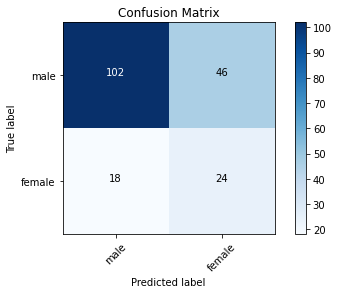

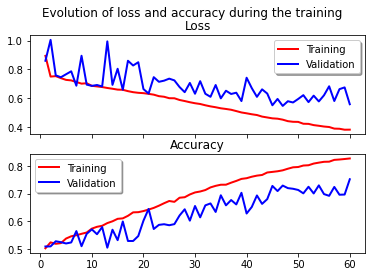

In [62]:
id='cnn_4_standardized_duprem_60_68'
model = cnn_4()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)
save_results(id, 'datatreat_A1 Standardization duplicate/remove', 'cnn_1', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)
plot_loss_acc_history(history, id, validation_split)

In [67]:
epochs=60
batch_size=69

In [65]:
X_train, X_test, y_train, prop_HF = datatreat_A1(x0=X, y0=y, x_final=X_final, train_size=0.8, Shuffle=True, preprocess="Standardization", ratio="50/50", balancing_method="duplicate/remove")

La proportion H/F des données d'entraînement est de 1.0
L'échantillon de training comporte 37840 frames


In [68]:
id='cnn_4'
model = cnn_4()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
save_model(model, id)
y_pred = test_1(model=model, X_test=X_test, id=id)
save_submission(y_pred, id)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 7, 500, 25)        275       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 7, 500, 25)        4375      
_________________________________________________________________
batch_normalization_108 (Bat (None, 7, 500, 25)        100       
_________________________________________________________________
activation_108 (Activation)  (None, 7, 500, 25)        0         
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 7, 167, 25)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 7, 167, 25)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 7, 167, 50)      

549/549 [==============================] - 22s 40ms/step - loss: 0.4379 - accuracy: 0.7918 - AUC: 0.8769
Epoch 44/60
549/549 [==============================] - 22s 40ms/step - loss: 0.4316 - accuracy: 0.7966 - AUC: 0.8808
Epoch 45/60
549/549 [==============================] - 22s 40ms/step - loss: 0.4300 - accuracy: 0.7939 - AUC: 0.8813
Epoch 46/60
549/549 [==============================] - 22s 40ms/step - loss: 0.4165 - accuracy: 0.8047 - AUC: 0.8902
Epoch 47/60
549/549 [==============================] - 22s 40ms/step - loss: 0.4212 - accuracy: 0.8035 - AUC: 0.8868
Epoch 48/60
549/549 [==============================] - 22s 40ms/step - loss: 0.4133 - accuracy: 0.8061 - AUC: 0.8912
Epoch 49/60
549/549 [==============================] - 22s 40ms/step - loss: 0.4150 - accuracy: 0.8062 - AUC: 0.8907
Epoch 50/60
549/549 [==============================] - 22s 40ms/step - loss: 0.3973 - accuracy: 0.8152 - AUC: 0.9005
Epoch 51/60
549/549 [==============================] - 22s 40ms/step - loss:

TypeError: object of type 'NoneType' has no len()

In [73]:
import csv

def save_submission(y_pred, id):
    with open(id + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["id", "label"])
        for i in range(y_pred.shape[0]):
            if y_pred[i]>0.5:
                writer.writerow([i, 1])
            else:
                writer.writerow([i, 0])

In [71]:
def test(predicts, y_test, id):
    predicts2=np.transpose(predicts>0.5)[0]
    accuracy=(np.count_nonzero(predicts2==y_test))/len(y_test)*100
    roc=roc_auc_score(y_test, predicts2)
    f1_macro=f1_score(y_test, predicts2, average='macro')
    f1_wei=f1_score(y_test, predicts2, average='weighted')

    print('')
    print('Accuracy : ' + str(accuracy))
    print('')
    print('ROC AUC : ' + str(roc))
    print('')
    print('f1 score (macro) : ' + str(f1_macro))
    print('')
    print('f1 score (weighted) : ' + str(f1_wei))
    
    cm = confusion_matrix(y_true=y_test, y_pred=predicts2)
    cm_labels = ['male','female']
    plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix', id=id)

    return accuracy, roc, f1_macro, f1_wei


def test_1(model, X_test, y_test=None, id=None, increase_dim=True):
    predicts=[]
    for i in range(40):
        X_test_i=X_test[:,i,:,:]
        if increase_dim:
            X_test_i=X_test_i.reshape(X_test_i.shape[0], X_test_i.shape[1], X_test_i.shape[2], 1)
        predicts.append(model.predict(X_test_i))
    predicts=np.mean(predicts, axis=0)

    if y_test is None:
        return predicts
    else:
        return test(predicts, y_test, id)

In [74]:
y_pred = test_1(model=model, X_test=X_test, id=id)
save_submission(y_pred, id)